In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
plt.style.use('dark_background')
import os,sys,glob, tqdm
import tifffile
import zarr

In [34]:
imaging_path = '/Users/danieldenman/Desktop/i3/i3_2022_6_23-13_5_15/'
stimulus_path = imaging_path#glob.glob(os.path.join(imaging_path,'c*'))[0]
imaging_path = glob.glob(stimulus_path+'/i*')[0]
image_list = glob.glob(os.path.join(imaging_path,'*Pos0*.tif'))
image_path = image_list[-1]

In [35]:
df_camera_triggers = pd.read_csv(os.path.join(stimulus_path,'TUcam_triggers.csv'),index_col=None,header=None)
df_grating_frames  = pd.read_csv(os.path.join(stimulus_path,'grating_frames.csv'),index_col=None,header=None)
df_gratings        = pd.read_csv(os.path.join(stimulus_path,'gratings.csv'),index_col=None)

### check the stimulus data

In [36]:
df_gratings.shape

(100, 3)

In [37]:
df_grating_frames.shape

(100, 5)

In [38]:
df_camera_triggers.shape[0]

7702

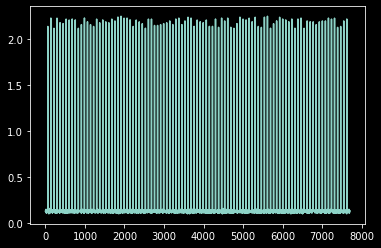

In [103]:
timestamps = np.array([row[1][1]*60+row[1][2]+row[1][3]/1000. for row in df_camera_triggers.iterrows()])
plt.plot(np.diff(timestamps))

In [10]:
starts=[timestamps[0]]
starts.extend([timestamps[s] for s in np.where(np.diff(timestamps) > 0.5)[0]])

### calculate some constants
number of frames per trial

In [13]:
print(len(trial))
frames_per_trial = len(trial)

76


size of the frame

In [26]:
with tifffile.TiffFile(image_path) as tif: print(tif.pages[2].asarray().shape)
with tifffile.TiffFile(image_path) as tif: image_dims=tif.pages[2].asarray().shape

(1216, 1824)


In [27]:
num_frames_per_tif = 965

# Load the data
load data with `zarr` to save memory<br>
`frame` x `space` x `space`

In [104]:
filename = image_list[0]
store = tifffile.imread(filename, aszarr=True)
zgroup = zarr.open(store, mode='r',rgb=False)
raw_movie = zgroup

/Users/danieldenman/opt/anaconda3/lib/python3.9/site-packages/zarr/creation.py:221: UserWarning: ignoring keyword argument 'rgb'
  warn('ignoring keyword argument %r' % k)


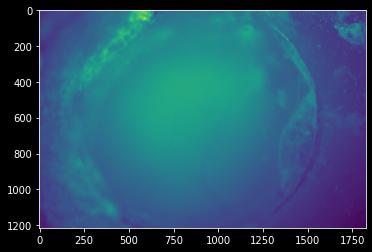

In [105]:
plt.imshow(raw_movie[0,:,:,])

## do dF/F for each trial 
dF/F = (F-F0)/F0

In [106]:
mean_dff = np.zeros((100,image_dims[0],image_dims[1]))
count = np.zeros(100)

#go through each trial (one stimulus)
for stim in tqdm.tqdm_notebook(range(df_gratings.shape[0]-1)):
    #get the indexes for this trial
    trial = np.where((timestamps > starts[stim]) & (timestamps < starts[stim+1]))[0]

    #get the baseline F for this trial (first image)
    baseline_image = raw_movie[trial[0],:,:]

    #subtract the baseline F from each other frame
    #add to grand average
    for i,trial_ in enumerate(trial[1:]):
        image = raw_movie[trial_,:,:]
        mean_dff[i,:,:] += (image-baseline_image)/baseline_image  # dF/F, a.k.a. (Fn - F0)/F0
        count[i]+=1              



/var/folders/ff/zqg2y83s5w72qygs0z5qq_900000gn/T/ipykernel_24269/1353186162.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for stim in tqdm.tqdm_notebook(range(df_gratings.shape[0]-1)):


  0%|          | 0/99 [00:00<?, ?it/s]

### calculate the trial average
this might not be properly aligned as is, if there are different numbers of frames captured from the camera per stimulus

In [91]:
mean_dff_avg = np.array([mean_dff[i,:,:] / count[i] for i in range(mean_dff.shape[0])])

/var/folders/ff/zqg2y83s5w72qygs0z5qq_900000gn/T/ipykernel_24269/732270051.py:1: RuntimeWarning: invalid value encountered in true_divide
  mean_dff_avg = np.array([mean_dff[i,:,:] / count[i] for i in range(mean_dff.shape[0])])


In [92]:
mean_dff_avg.shape

(100, 1216, 1824)

check the scales of the accumulated data

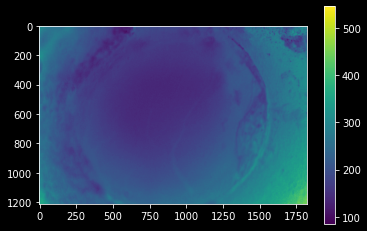

In [94]:
plt.imshow(mean_dff[20,:,:])
plt.colorbar()

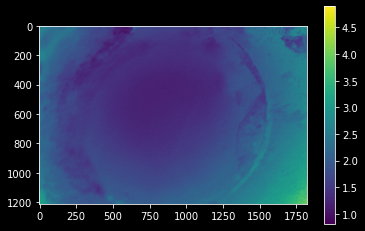

In [95]:
plt.imshow(mean_dff_avg[40,:,:])
plt.colorbar()

# plot each image across time

In [116]:
# for i in range(75):
#     plt.figure()
#     f_=plt.imshow(mean_dff_avg[i,:,:],clim=(-0.03,3))
# plt.colorbar(f_)

# make a quick slider for viewing

In [115]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

def plot_func(i):
    plt.imshow(mean_dff_avg[int(i),:,:],clim=(-0.03,3))

interact(plot_func, i = widgets.FloatSlider(value=10,
                                               min=1,
                                               max=75,
                                               step=1))

interactive(children=(FloatSlider(value=10.0, description='i', max=75.0, min=1.0, step=1.0), Output()), _dom_c…

<function __main__.plot_func(i)>

# plot a temporal line plot through each frame
the pixels is hardcoded on the first line

Text(0.5, 0, 'frame number')

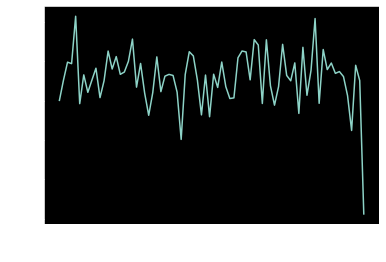

In [117]:
plt.plot(mean_dff_avg[:,380,1250]) # specifiy the row, column where you want the line plot
plt.ylabel('dF/F')
plt.xlabel('frame number')
# plt.ylim(-0.03,0.1)